<a href="https://colab.research.google.com/github/2yeeji/test-django/blob/main/%ED%92%88%EC%A7%88%EA%B3%B5%ED%95%99_hw6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. T2 관리도 생성 및 해석

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab Notebooks/품질공학'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/품질공학


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tabulate import tabulate
from scipy.stats import beta

In [ ]:
df = pd.read_csv('hybrid_manufacturing_categorical.csv') # kaggle 'ziya07/manufacturing-production-data' 데이터
df.head()

,Job_ID,Machine_ID,Operation_Type,Material_Used,Processing_Time,Energy_Consumption,Machine_Availability,Scheduled_Start,Scheduled_End,Actual_Start,Actual_End,Job_Status,Optimization_Category
0,J001,M01,Grinding,3.17,76,11.42,96,2023-03-18 08:00:00,2023-03-18 09:16:00,2023-03-18 08:05:00,2023-03-18 09:21:00,Completed,Moderate Efficiency
1,J002,M01,Grinding,3.35,79,6.61,84,2023-03-18 08:10:00,2023-03-18 09:29:00,2023-03-18 08:20:00,2023-03-18 09:39:00,Delayed,Low Efficiency
2,J003,M04,Additive,2.29,56,11.11,92,2023-03-18 08:20:00,2023-03-18 09:16:00,NaN,NaN,Failed,Low Efficiency
3,J004,M04,Grinding,1.76,106,12.50,95,2023-03-18 08:30:00,2023-03-18 10:16:00,2023-03-18 08:35:00,2023-03-18 10:21:00,Completed,Moderate Efficiency
4,J005,M01,Lathe,1.90,46,8.13,88,2023-03-18 08:40:00,2023-03-18 09:26:00,2023-03-18 08:42:00,2023-03-18 09:28:00,Completed,High Efficiency


In [ ]:
df = df.iloc[:, 3:7]
df.head()

,Material_Used,Processing_Time,Energy_Consumption,Machine_Availability
0,3.17,76,11.42,96
1,3.35,79,6.61,84
2,2.29,56,11.11,92
3,1.76,106,12.50,95
4,1.90,46,8.13,88


In [ ]:
def t_square(data, alpha: float = None):

    array_data = np.array(data)
    num_sample = len(data)

    p = array_data.shape[1]

    col_mean = np.mean(array_data, axis=0)  # column mean
    mat_cov = np.cov(array_data.T)  # covariance
    mat_inv_s = np.linalg.inv(mat_cov)  # inverse S

    values = []
    for sample in array_data:
        dif = sample - col_mean
        value = mat_inv_s.dot(dif.T).dot(dif)  # T-square
        values.append(value)

    CL = (np.power((num_sample -1), 2)) / num_sample
    LCL = 0

    UCL = CL * beta.ppf((1-alpha), p/2, (num_sample - p - 1)/2)

    return values, LCL, UCL

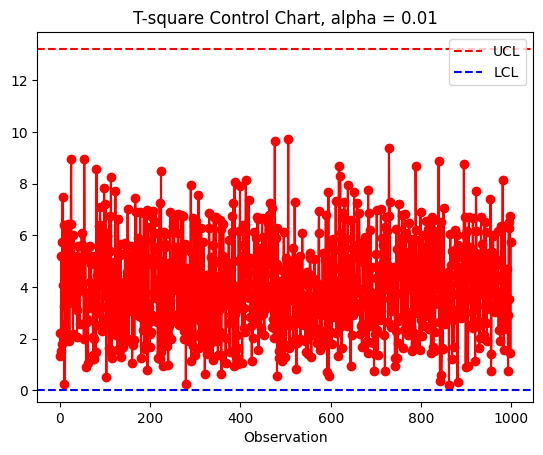

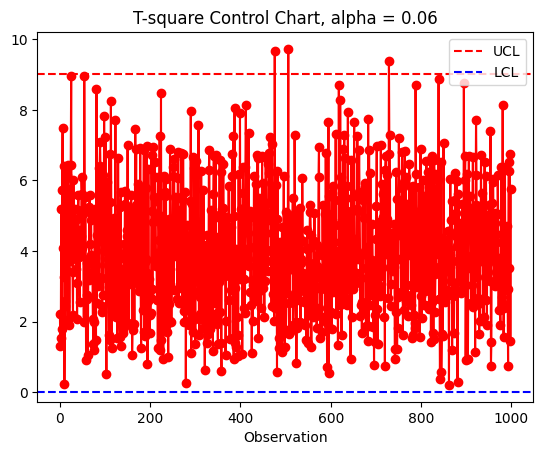

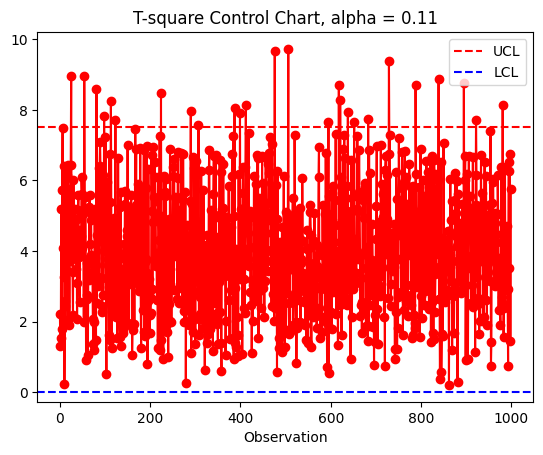

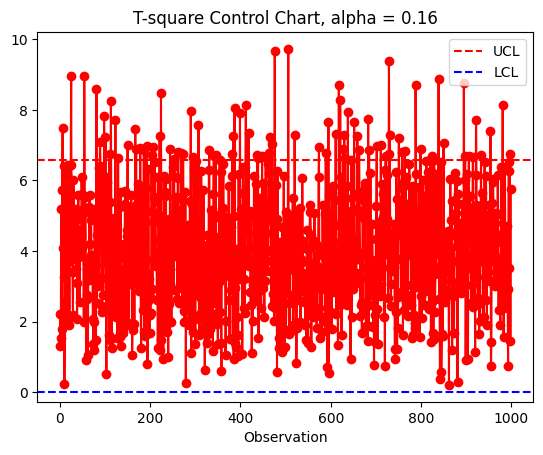

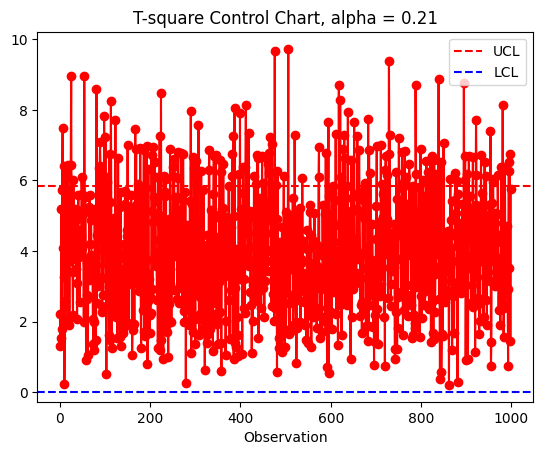

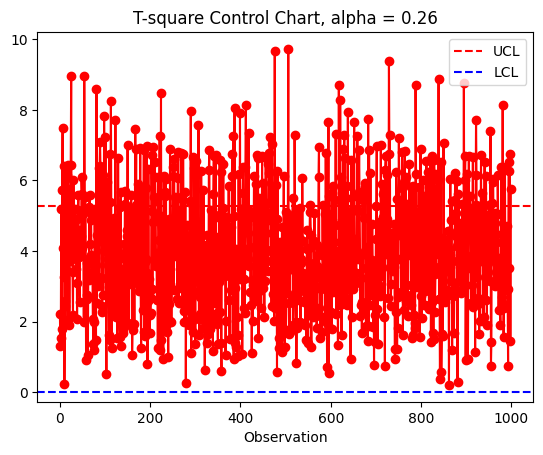

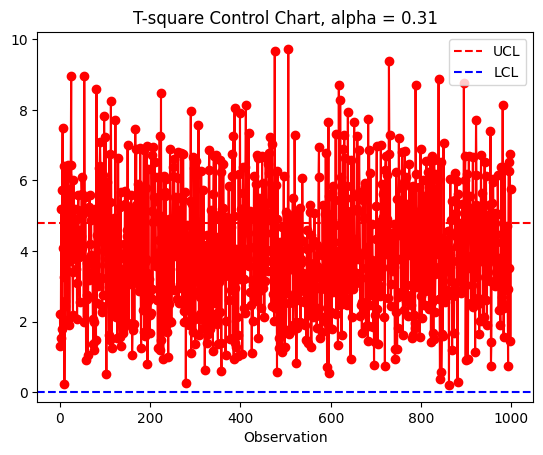

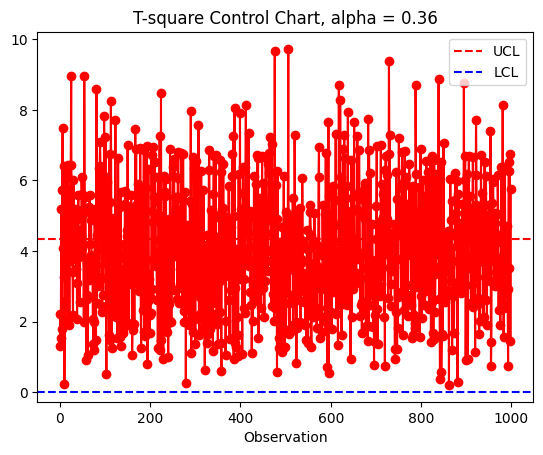

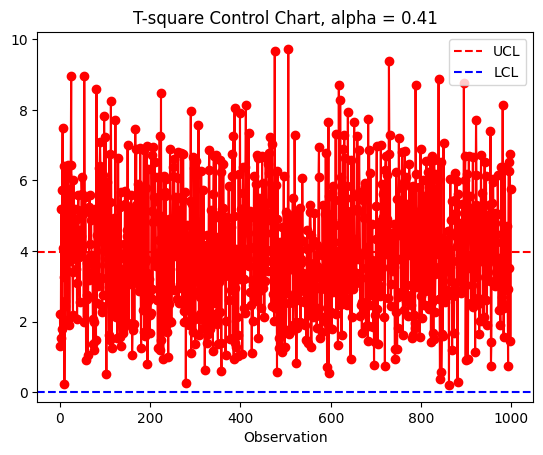

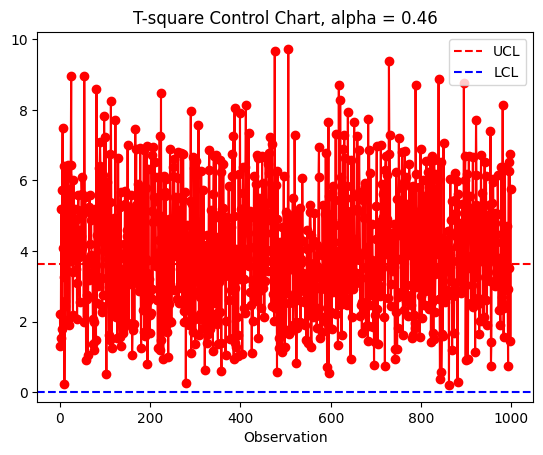

In [ ]:
alphas = np.arange(0.01, 0.5, 0.05)

for alpha in alphas:
    values, LCL, UCL = t_square(df, alpha=alpha)

    plt.plot(values, marker='o', color='r')
    plt.axhline(UCL, color='r', label='UCL', linestyle='--')
    # plt.axhline(center, color='black', label='Center')
    plt.axhline(LCL, color='b', label='LCL', linestyle='--')
    plt.legend()
    plt.title(f'T-square Control Chart, alpha = {np.round(alpha,3)}')
    plt.xlabel('Observation')
    plt.show()


alpha 값이 커질수록 UCL이 낮아지고, 더 많은 관측치가 CL을 벗어나게 되는 것을 알 수 있다. 이를 통해 alpha가 커지면 알람이 많이 울리고, sensitivity가 높아지나, 많은 알람으로 인해 피로도가 높아질 수 있음을 알 수 있다.

* alpha = 정상인데 비정상으로 오판할 확률

## 2. 비정규분포 생성 및 F분포와 bootstrap을 이용한 관리 한계선 비교

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import gamma, multivariate_normal, multivariate_t, beta, f
import matplotlib.pyplot as plt

In [ ]:
def t2_control_limit(data, alpha: float, data_dist_name: str , bs_size: int=100):
    array_data = np.array(data)
    m = len(data) # number of samples
    p = array_data.shape[1] # number of variables

    x_mean = np.mean(array_data, axis=0) # mean of variables
    cov = np.cov(array_data.T) # covariance
    cov_inv = np.linalg.inv(cov) # inverse S

    t2_values = []
    for sample in array_data:
        dif = sample - x_mean
        t2 = (dif.T).dot(cov_inv).dot(dif)  # T-square
        t2_values.append(t2)

    # control limit with f distribution
    CL = (p*(m+1)*(m-1))/(m*(m-p))
    UCL_f = CL * f.ppf(1-alpha, p, m-p)

    # control limit with bootstrap
    quantile_list = []
    for i in range(bs_size):
        samples = np.random.choice(t2_values, size=len(t2_values), replace=True)
        quantile = np.quantile(samples, 1-alpha)
        quantile_list.append(quantile)
    UCL_bs = np.mean(quantile_list)

    # plot control chart
    plt.figure(figsize=(10,5))
    plt.plot(t2_values, color='b')
    plt.axhline(UCL_f, color='r', label='F distribution', linestyle='--')
    plt.axhline(UCL_bs, color='g', label='Bootstrap', linestyle='--')
    plt.legend()
    plt.title(f'T2 Control Chart(F vs Bootstrap), {data_dist_name}, alpha = {alpha}', fontweight='bold')
    plt.ylim((0,100))
    plt.xlabel('Observation')
    plt.ylabel('T2')
    plt.show()

    print('-'*10+' False alarm with F distribution '+'-'*10)
    print(f'Expected false alarm rate: {alpha}')
    print(f'Data false alarm rate: {(t2_values > UCL_f).sum()/len(data)}')

    print('-'*10+' False alarm with Bootstrap '+'-'*10)
    print(f'Expected false alarm rate: {alpha}')
    print(f'Data false alarm rate: {(t2_values > UCL_bs).sum()/len(data)}')

In [ ]:
### Parmeters non-normal distribtuion
# Gamma shape parameter small (0.1)
# Log-normal variance big (1.0)
# t degree of freedom small (1)

n_sample = 500

########## Gamma Distribution ##########
# parameter of multivariate gamma distribution
shape_list = [0.2, 0.5, 1.0]
scale_list = [1.0, 2.0, 0.5]

# generate data
data_multi_gamma = pd.DataFrame()
for i, (shape, scale) in enumerate(zip(shape_list, scale_list)):
    data = gamma(a=shape, scale=scale).rvs(size=n_sample)
    data_multi_gamma = pd.concat([data_multi_gamma, pd.DataFrame(data, columns=[f'X{i+1}'])], axis=1)

########## Log-normal distribution ##########
# parameter of multivariate normal distribution
mean = [0.0, 1.0, 2.0]
cov = [[1.2, 0.0, 0.0],
       [0.0, 1.5, 0.0],
       [0.0, 0.0, 2.0]]

# generate data
data_multi_normal = multivariate_normal(mean=mean, cov=cov).rvs(size=n_sample) # log(X)
data_multi_log_normal = np.exp(data_multi_normal) # log(X) -> X

########## t distribution ##########
# parameter multivariate t distribution
# parameter of multivariate normal distribution
loc = [0.0, 1.0, 2.0]
df = 1

# generate data
data_multi_t = multivariate_t(loc=loc, df=df).rvs(size=n_sample)

########## Beta distribution ##########
# parameter multivariate beta distribution
alpha = [0.5, 2, 5]
beta_param = [2, 0.5, 1]

# generate data
data_multi_beta = pd.DataFrame()
for i, (a, b) in enumerate(zip(alpha, beta_param)):
    data = beta(a, b).rvs(size=n_sample)
    data_multi_beta = pd.concat([data_multi_beta, pd.DataFrame(data, columns=[f'X{i+1}'])], axis=1)


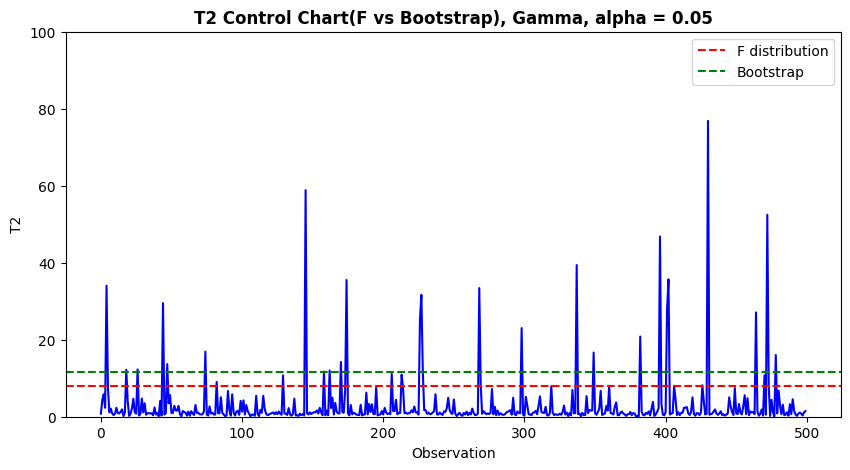

---------- False alarm with F distribution ----------
Expected false alarm rate: 0.05
Data false alarm rate: 0.072
---------- False alarm with Bootstrap ----------
Expected false alarm rate: 0.05
Data false alarm rate: 0.05


In [ ]:
# Gamma distribution T2 control chart
alpha = 0.05
t2_control_limit(data=data_multi_gamma, alpha=alpha, data_dist_name='Gamma')

F 분포에서는 정규 분포를 가정하는데, 해당 가정이 깨져서 더 많은 false alarm이 발생함.

Bootstrap에서는 실제 분포가 반영되어 false alarm이 정확하게 유지됨.

F 분포의 Control Limit이 Bootstrap보다 더 낮게 설정되어, false alarm이 증가함.

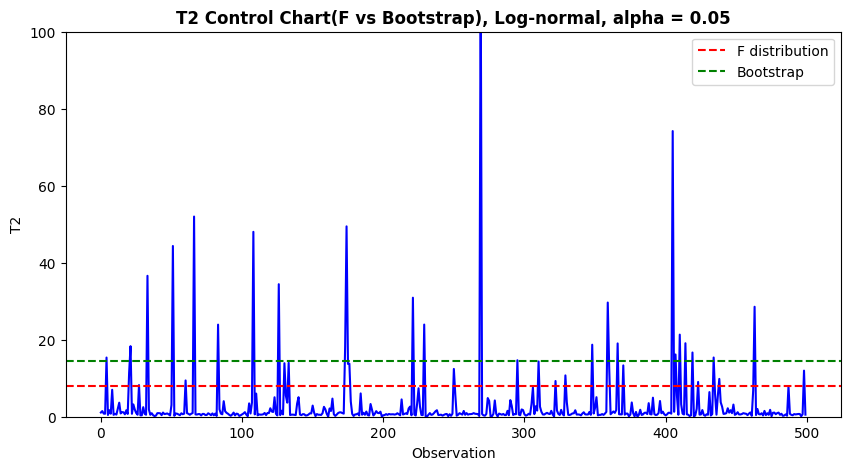

---------- False alarm with F distribution ----------
Expected false alarm rate: 0.05
Data false alarm rate: 0.08
---------- False alarm with Bootstrap ----------
Expected false alarm rate: 0.05
Data false alarm rate: 0.048


In [ ]:
# Log-normal distribution T2 control chart
alpha = 0.05
t2_control_limit(data=data_multi_log_normal, alpha=alpha, data_dist_name='Log-normal')

log-normal 분포는 heavy right tail을 가지는 비정규 분포이나, F 분포는 정규성 가정을 전제로 하므로, Control LImit이 너무 낮아지는 현상이 발생하여 false alarm이 많아지는 결과를 낳게 됨.

Bootstrap에서는 실제 분포가 반영되어 Control Limit이 더 높게 설정되는 것을 볼 수 있음.

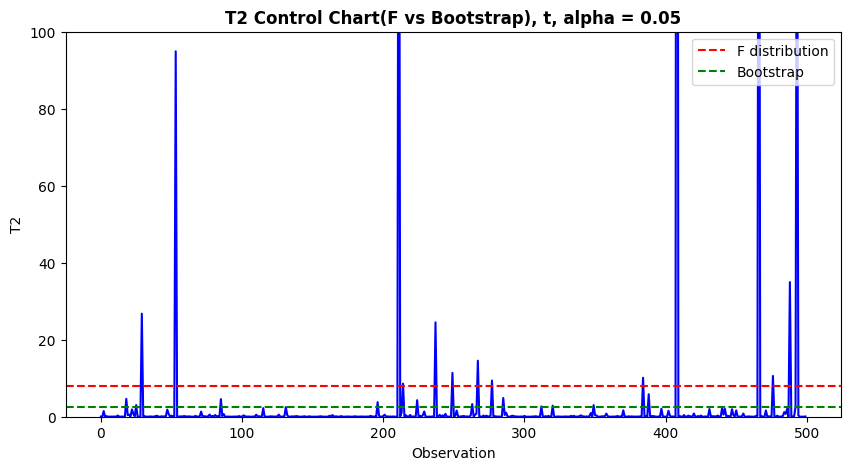

---------- False alarm with F distribution ----------
Expected false alarm rate: 0.05
Data false alarm rate: 0.028
---------- False alarm with Bootstrap ----------
Expected false alarm rate: 0.05
Data false alarm rate: 0.05


In [ ]:
# t distribution T2 control chart
alpha = 0.05
t2_control_limit(data=data_multi_t, alpha=alpha, data_dist_name='t')

df=1인 t분포는 tail이 매우 두꺼우며, 값들이 극단적으로 크거나 작은 분포를 보임. 오히려 Control Limit을 넘는 빈도가 줄어들어 false alarm이 감소한 것을 알 수 있음.

Bootstrap은 실제 분포 특성을 고려하여 Control Limit이 설정된 것을 알 수 있음.

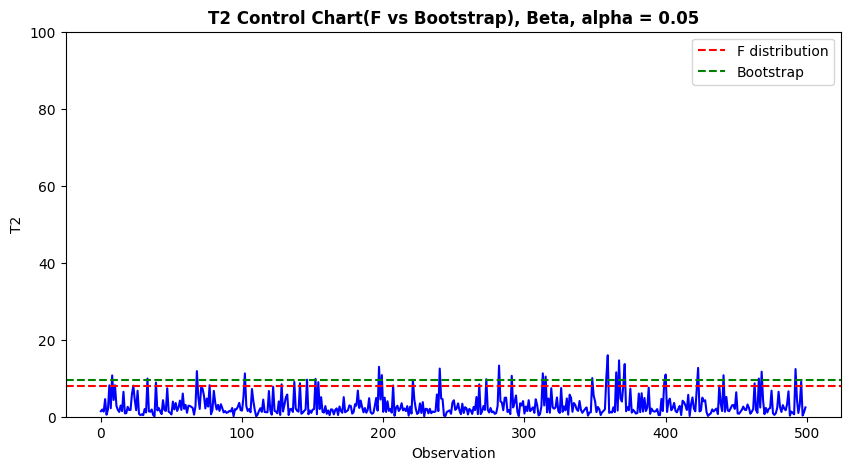

---------- False alarm with F distribution ----------
Expected false alarm rate: 0.05
Data false alarm rate: 0.086
---------- False alarm with Bootstrap ----------
Expected false alarm rate: 0.05
Data false alarm rate: 0.054


In [ ]:
# t distribution T2 control chart
alpha = 0.05
t2_control_limit(data=data_multi_beta, alpha=alpha, data_dist_name='Beta')

Beta 분포는 tail이 짧고 변화 폭이 제한되어 있으나, F 분포의 Control Limit이 상대적으로 낮게 설정되어 false alarm이 증가함.

Bootstrap은 실제 분포를 반영하여 더 적절한 Control Limit을 생성함.

정규분포를 따르지 않을 시, Bootstrap을 이용하여 실제 데이터 분포를 반영하도록 할 필요가 있음.

## 3. 거리의 특징과 종류

1. Euclidean distance

- L2 Distance, L2 Norm이라고도 하며, 벡터의 요소의 차이의 제곱의 합에 제곱근을 씌워준 것과 동일함.

- 가장 직관적인 거리 개념(직선거리).

- 큰 차이에 민감 → 노이즈나 이상치(outlier)의 영향이 큼.

- 회전 변환(rotation)에 대해 불변.

- 고차원 데이터에서는 curse of dimensionality 문제가 상대적으로 더 심해짐.

2. Manhattan Distance

- L1 Distance, L1 Norm이라고도 하며, n차원 공간에 위치한 두 점 p, q 사이의 거리는 각 좌표의 차이의 절댓값을 모두 합한 것과 동일함.

- 좌표축에 평행한 경로만 이동하는 거리 → 격자형(grid-like) 구조에 적합.

- 이상치에 더 강함(L2보다 변화량 작게 반응).

- Lasso( L1 regularization )와 동일한 수학적 구조.

3. Minkowski Distance

- p 값 조절로 L1~L∞까지 포함하는 범용 거리 함수.

- p가 커질수록 큰 좌표 차이에 더 민감.

- p 선택이 모델 성능에 영향을 줄 수 있어 실험적으로 조정 필요.

4. Chebyshev Distance

- L∞ Norm 이라고도 하며, 벡터 성분의 절댓값 중 가장 큰 값으로 거리 계산.

- 등거리선이 정사각형 형태(유클리드의 원형과 대비).

- 두 점이 k차원 공간에서 동시에 제한 조건을 만족해야 할 때 유용.

## 4. 10년 전 나 자신에게의 편지

중학교 1학년이 어느덧 마무리되어 갈 텐데, 입학 전 생각했던 생활과 비슷했을까?

지금 있는 그 곳은 생각보다 더 좁은 세상이야. 그러니 조금 더 바깥을 보고, 다양한 경험을 하려 노력하고, 새로운 것들을 배우고자 했으면 좋겠어.

10년이라는 시간이 흐르고 보니 영어를 더 공부하지 않은 것, 중국어를 배워보지 못한 것, 피아노를 끈기있게 계속 치지 못했던 것 등 여러 아쉬움이 남는 것 같아.

살다보면 분명 여러 기회가 찾아올 텐데, 그 때 기회를 놓치지 않을 수 있도록 노력하면 좋을 것 같아.